In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint

In [2]:
# Load the training and testing datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [3]:
# Display the first few rows of each dataset to verify
print("Training Data:")
print(train_data.head())

print("\nTesting Data:")
print(test_data.head())

Training Data:
   id class  cap-diameter cap-shape cap-surface cap-color  \
0   0     e          8.80         f           s         u   
1   1     p          4.51         x           h         o   
2   2     e          6.94         f           s         b   
3   3     e          3.88         f           y         g   
4   4     e          5.85         x           l         w   

  does-bruise-or-bleed gill-attachment gill-spacing gill-color  ...  \
0                    f               a            c          w  ...   
1                    f               a            c          n  ...   
2                    f               x            c          w  ...   
3                    f               s          NaN          g  ...   
4                    f               d          NaN          w  ...   

   stem-root  stem-surface stem-color veil-type veil-color has-ring ring-type  \
0        NaN           NaN          w       NaN        NaN        f         f   
1        NaN             y   

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [5]:
# check which columns have null values and how much
missing_values = train_data.isnull().sum()
missing_values[missing_values > 0]

cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
dtype: int64

In [6]:
# Count missing values for each column
missing_values = train_data.isnull().sum()

# Filter columns with missing values
missing_values = missing_values[missing_values > 0]

# Calculate percentage of missing values
missing_percentage = (missing_values / len(train_data)) * 100

# Display the result
missing_percentage


cap-diameter             0.000128
cap-shape                0.001283
cap-surface             21.528227
cap-color                0.000385
does-bruise-or-bleed     0.000257
gill-attachment         16.809280
gill-spacing            40.373988
gill-color               0.001829
stem-root               88.452732
stem-surface            63.551362
stem-color               0.001219
veil-type               94.884350
veil-color              87.936970
has-ring                 0.000770
ring-type                4.134818
spore-print-color       91.425482
habitat                  0.001444
dtype: float64

In [7]:
# Calculate the percentage of missing values for each column
missing_percentage = (train_data.isnull().sum() / len(train_data)) * 100

# Filter the columns that have less than or equal to 25% missing values
train_data_cleaned = train_data.loc[:, missing_percentage <= 25]

# Display the cleaned DataFrame
train_data_cleaned


,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,0,e,8.80,f,s,u,f,a,w,4.51,15.39,w,f,f,d,a
1,1,p,4.51,x,h,o,f,a,n,4.79,6.48,o,t,z,d,w
2,2,e,6.94,f,s,b,f,x,w,6.85,9.93,n,f,f,l,w
3,3,e,3.88,f,y,g,f,s,g,4.16,6.53,w,f,f,d,u
4,4,e,5.85,x,l,w,f,d,w,3.37,8.36,w,f,f,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,3116940,e,9.29,f,NaN,n,t,NaN,w,12.14,18.81,w,t,g,d,u
3116941,3116941,e,10.88,s,NaN,w,t,d,p,6.65,26.97,w,f,f,d,u
3116942,3116942,p,7.82,x,e,e,f,a,w,9.51,11.06,y,t,z,d,a
3116943,3116943,e,9.45,p,i,n,t,e,p,9.13,17.77,w,t,p,d,u


In [8]:
# Function to fill missing values based on data type
def fill_missing_values(df):
    for column in df.columns:
        if df[column].dtype == 'object':  # If the column is categorical
            df[column].fillna(df[column].mode()[0], inplace=True)
        else:  # If the column is numeric
            df[column].fillna(df[column].median(), inplace=True)

# Fill missing values in the cleaned dataset
fill_missing_values(train_data_cleaned)

# Display the dataset after filling missing values
train_data_cleaned


C:\Users\MSI-Z490\AppData\Local\Temp\ipykernel_20920\3945372426.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].fillna(df[column].median(), inplace=True)
C:\Users\MSI-Z490\AppData\Local\Temp\ipykernel_20920\3945372426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].fillna(df[column].mode()[0], inplace=True)
C:\Users\MSI-Z490\AppData\Local\Temp\ipykernel_20920\3945372426.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,0,e,8.80,f,s,u,f,a,w,4.51,15.39,w,f,f,d,a
1,1,p,4.51,x,h,o,f,a,n,4.79,6.48,o,t,z,d,w
2,2,e,6.94,f,s,b,f,x,w,6.85,9.93,n,f,f,l,w
3,3,e,3.88,f,y,g,f,s,g,4.16,6.53,w,f,f,d,u
4,4,e,5.85,x,l,w,f,d,w,3.37,8.36,w,f,f,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,3116940,e,9.29,f,t,n,t,a,w,12.14,18.81,w,t,g,d,u
3116941,3116941,e,10.88,s,t,w,t,d,p,6.65,26.97,w,f,f,d,u
3116942,3116942,p,7.82,x,e,e,f,a,w,9.51,11.06,y,t,z,d,a
3116943,3116943,e,9.45,p,i,n,t,e,p,9.13,17.77,w,t,p,d,u


In [9]:
train_data_cleaned['cap-shape'] = train_data_cleaned['cap-shape'].apply(lambda x: 'others' if x not in ['b', 'c', 'x', 'f', 'k', 's'] else x)

train_data_cleaned['cap-surface'] = train_data_cleaned['cap-surface'].apply(lambda x: 'others' if x not in ['f', 'g', 'y', 's'] else x)

train_data_cleaned['gill-attachment'] = train_data_cleaned['gill-attachment'].apply(lambda x: 'others' if x not in ['a', 'd', 'f', 'n'] else x)

train_data_cleaned['cap-color'] = train_data_cleaned['cap-color'].apply(lambda x: 'others' if x not in ['n', 'b', 'c', 'g', 'r', 'p', 'u', 'e', 'w', 'y'] else x)

train_data_cleaned['stem-color'] = train_data_cleaned['stem-color'].apply(lambda x: 'others' if x not in ['b', 'c', 'e', 'g', 'n', 'o', 'p', 'u', 'w', 'y'] else x)

train_data_cleaned['does-bruise-or-bleed'] = train_data_cleaned['does-bruise-or-bleed'].apply(lambda x: 'others' if x not in ['f', 't'] else x)

train_data_cleaned['gill-color'] = train_data_cleaned['gill-color'].apply(lambda x: 'others' if x not in ['k', 'n', 'b', 'h', 'g', 'r', 'o', 'p', 'u', 'e', 'w', 'y'] else x)

train_data_cleaned['ring-type'] = train_data_cleaned['ring-type'].apply(lambda x: 'others' if x not in ['c', 'e', 'f', 'l', 'n', 'p', 's', 'z'] else x)

train_data_cleaned['has-ring'] = train_data_cleaned['has-ring'].apply(lambda x: 'others' if x not in ['f', 't'] else x)

train_data_cleaned['habitat'] = train_data_cleaned['habitat'].apply(lambda x: 'others' if x not in ['g', 'l', 'm', 'p', 'u', 'd', 'w'] else x)

C:\Users\MSI-Z490\AppData\Local\Temp\ipykernel_20920\4107681411.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_cleaned['cap-shape'] = train_data_cleaned['cap-shape'].apply(lambda x: 'others' if x not in ['b', 'c', 'x', 'f', 'k', 's'] else x)
C:\Users\MSI-Z490\AppData\Local\Temp\ipykernel_20920\4107681411.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_cleaned['cap-surface'] = train_data_cleaned['cap-surface'].apply(lambda x: 'others' if x not in ['f', 'g', 'y', 's'] else x)
C:

In [10]:
import pandas as pd

# Example DataFrames
# trained_data_cleaned = pd.DataFrame(...)
# test_data = pd.DataFrame(...)

# Keep only the columns in test_data that are also in trained_data_cleaned
test_data_cleaned = test_data[train_data_cleaned.columns.intersection(test_data.columns)]

# Alternatively, you can also use this if you want to drop columns not in trained_data_cleaned
test_data_cleaned = test_data.loc[:, test_data.columns.isin(train_data_cleaned.columns)]

# Now, test_data_cleaned will only contain columns present in trained_data_cleaned


In [11]:
test_data_cleaned['cap-shape'] = test_data_cleaned['cap-shape'].apply(lambda x: 'others' if x not in ['b', 'c', 'x', 'f', 'k', 's'] else x)

test_data_cleaned['cap-surface'] = test_data_cleaned['cap-surface'].apply(lambda x: 'others' if x not in ['f', 'g', 'y', 's'] else x)

test_data_cleaned['gill-attachment'] = test_data_cleaned['gill-attachment'].apply(lambda x: 'others' if x not in ['a', 'd', 'f', 'n'] else x)

test_data_cleaned['cap-color'] = test_data_cleaned['cap-color'].apply(lambda x: 'others' if x not in ['n', 'b', 'c', 'g', 'r', 'p', 'u', 'e', 'w', 'y'] else x)

test_data_cleaned['stem-color'] = test_data_cleaned['stem-color'].apply(lambda x: 'others' if x not in ['b', 'c', 'e', 'g', 'n', 'o', 'p', 'u', 'w', 'y'] else x)

test_data_cleaned['does-bruise-or-bleed'] = test_data_cleaned['does-bruise-or-bleed'].apply(lambda x: 'others' if x not in ['f', 't'] else x)

test_data_cleaned['gill-color'] = test_data_cleaned['gill-color'].apply(lambda x: 'others' if x not in ['k', 'n', 'b', 'h', 'g', 'r', 'o', 'p', 'u', 'e', 'w', 'y'] else x)

test_data_cleaned['ring-type'] = test_data_cleaned['ring-type'].apply(lambda x: 'others' if x not in ['c', 'e', 'f', 'l', 'n', 'p', 's', 'z'] else x)

test_data_cleaned['has-ring'] = test_data_cleaned['has-ring'].apply(lambda x: 'others' if x not in ['f', 't'] else x)

test_data_cleaned['habitat'] = test_data_cleaned['habitat'].apply(lambda x: 'others' if x not in ['g', 'l', 'm', 'p', 'u', 'd', 'w'] else x)

C:\Users\MSI-Z490\AppData\Local\Temp\ipykernel_20920\837137354.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_cleaned['cap-shape'] = test_data_cleaned['cap-shape'].apply(lambda x: 'others' if x not in ['b', 'c', 'x', 'f', 'k', 's'] else x)
C:\Users\MSI-Z490\AppData\Local\Temp\ipykernel_20920\837137354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_cleaned['cap-surface'] = test_data_cleaned['cap-surface'].apply(lambda x: 'others' if x not in ['f', 'g', 'y', 's'] else x)
C:\Users

In [12]:
# Statistical summary
train_data_cleaned.describe(include='all')

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
count,3.116945e+06,3116945,3.116945e+06,3116945,3116945,3116945,3116945,3116945,3116945,3.116945e+06,3.116945e+06,3116945,3116945,3116945,3116945,3116945
unique,NaN,2,NaN,7,5,11,3,5,13,NaN,NaN,11,3,9,8,4
top,NaN,p,NaN,x,others,n,f,others,w,NaN,NaN,w,f,f,d,a
freq,NaN,1705396,NaN,1436066,2140345,1359554,2569751,1237766,931595,NaN,NaN,1196675,2368844,2606050,2177618,1543321
mean,1.558472e+06,NaN,6.309848e+00,NaN,NaN,NaN,NaN,NaN,NaN,6.348333e+00,1.115379e+01,NaN,NaN,NaN,NaN,NaN
std,8.997847e+05,NaN,4.657928e+00,NaN,NaN,NaN,NaN,NaN,NaN,2.699755e+00,8.095477e+00,NaN,NaN,NaN,NaN,NaN
min,0.000000e+00,NaN,3.000000e-02,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
25%,7.792360e+05,NaN,3.320000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.670000e+00,4.970000e+00,NaN,NaN,NaN,NaN,NaN
50%,1.558472e+06,NaN,5.750000e+00,NaN,NaN,NaN,NaN,NaN,NaN,5.880000e+00,9.650000e+00,NaN,NaN,NaN,NaN,NaN
75%,2.337708e+06,NaN,8.240000e+00,NaN,NaN,NaN,NaN,NaN,NaN,7.410000e+00,1.563000e+01,NaN,NaN,NaN,NaN,NaN


<Axes: title={'center': 'Class Distribution'}, xlabel='class'>

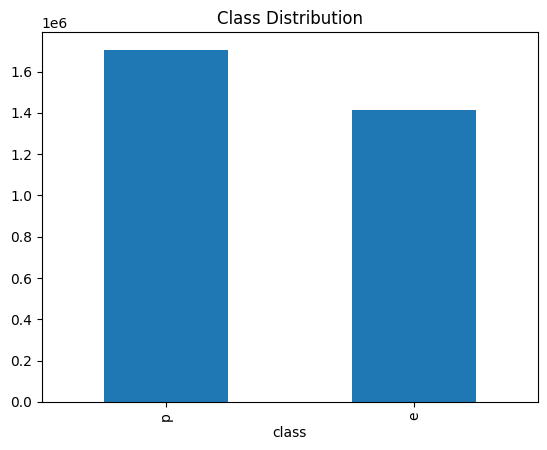

In [13]:
# Class distribution
class_distribution = train_data_cleaned['class'].value_counts()
class_distribution.plot(kind='bar', title='Class Distribution')


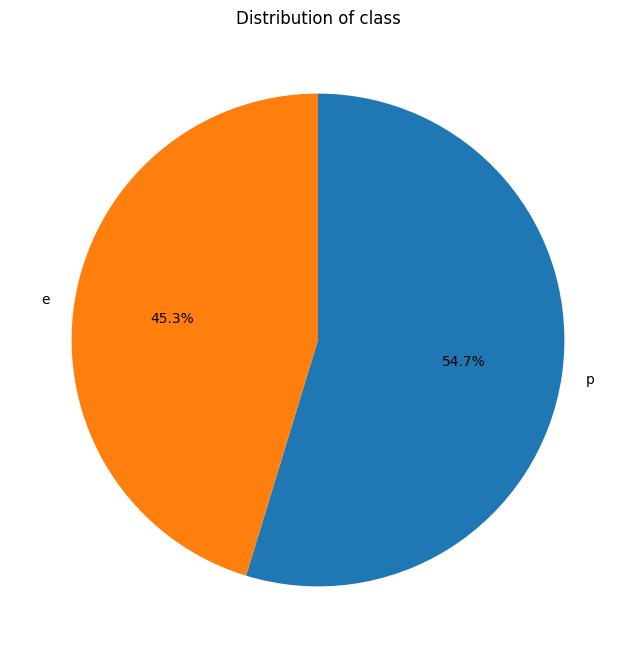

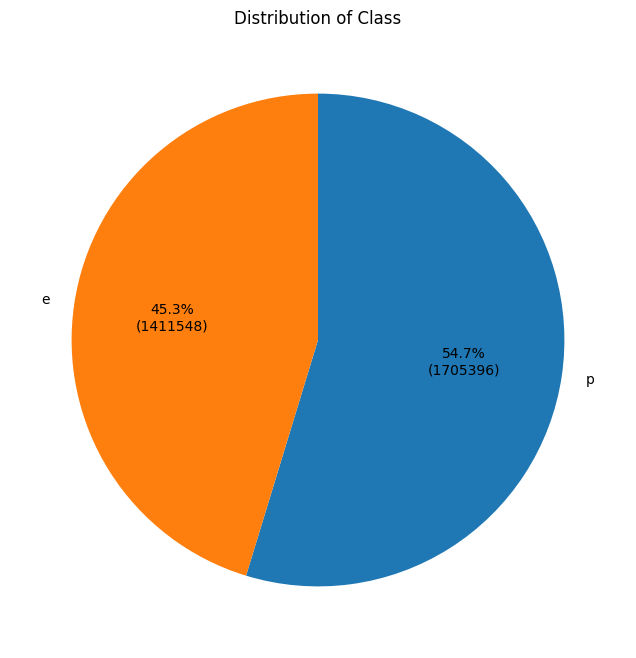

In [14]:
import matplotlib.pyplot as plt

# Choose a column to visualize (replace 'column_name' with the actual column you want to plot)
column_to_plot = 'class'

# Calculate the counts for each category in the selected column
category_counts = train_data_cleaned[column_to_plot].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, counterclock=False)

# Add title
plt.title(f'Distribution of {column_to_plot}')

# Display the pie chart
plt.show()

import matplotlib.pyplot as plt

# Calculate the counts for each category in the "class" column
category_counts = train_data_cleaned['class'].value_counts()

# Define a function to display both the percentage and count on the pie chart
def autopct_with_count(pct, all_values):
    absolute = int(pct / 100. * sum(all_values))
    return f'{pct:.1f}%\n({absolute})'

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, 
        autopct=lambda pct: autopct_with_count(pct, category_counts), 
        startangle=90, counterclock=False)

# Add title
plt.title('Distribution of Class')

# Display the pie chart
plt.show()



In [15]:
class_p =train_data_cleaned[train_data_cleaned['class'] == 'p']
class_e = train_data_cleaned[train_data_cleaned['class'] == 'e']

In [16]:
class_e.describe(include='all')

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
count,1.411549e+06,1411549,1.411549e+06,1411549,1411549,1411549,1411549,1411549,1411549,1.411549e+06,1.411549e+06,1411549,1411549,1411549,1411549,1411549
unique,NaN,1,NaN,7,5,11,3,5,13,NaN,NaN,11,3,9,8,4
top,NaN,e,NaN,x,others,n,f,others,w,NaN,NaN,w,f,f,d,a
freq,NaN,1411549,NaN,703427,886126,692131,1141579,682633,532457,NaN,NaN,696806,1105649,1200751,1026010,661180
mean,1.558606e+06,NaN,7.142470e+00,NaN,NaN,NaN,NaN,NaN,NaN,6.495937e+00,1.266478e+01,NaN,NaN,NaN,NaN,NaN
std,8.995173e+05,NaN,5.385684e+00,NaN,NaN,NaN,NaN,NaN,NaN,2.583245e+00,7.690701e+00,NaN,NaN,NaN,NaN,NaN
min,0.000000e+00,NaN,3.000000e-02,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
25%,7.794350e+05,NaN,4.040000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.980000e+00,6.690000e+00,NaN,NaN,NaN,NaN,NaN
50%,1.559053e+06,NaN,6.520000e+00,NaN,NaN,NaN,NaN,NaN,NaN,6.060000e+00,1.204000e+01,NaN,NaN,NaN,NaN,NaN
75%,2.337049e+06,NaN,9.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,7.350000e+00,1.749000e+01,NaN,NaN,NaN,NaN,NaN


More smooth cap surfaces

In [17]:
class_p.describe(include='all')

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
count,1.705396e+06,1705396,1.705396e+06,1705396,1705396,1705396,1705396,1705396,1705396,1.705396e+06,1.705396e+06,1705396,1705396,1705396,1705396,1705396
unique,NaN,1,NaN,7,5,11,3,5,13,NaN,NaN,11,3,9,8,4
top,NaN,p,NaN,x,others,n,f,a,w,NaN,NaN,n,f,f,d,a
freq,NaN,1705396,NaN,732639,1254219,667423,1428172,752340,399138,NaN,NaN,613044,1263195,1405299,1151608,882141
mean,1.558361e+06,NaN,5.620690e+00,NaN,NaN,NaN,NaN,NaN,NaN,6.226162e+00,9.903143e+00,NaN,NaN,NaN,NaN,NaN
std,9.000061e+05,NaN,3.820691e+00,NaN,NaN,NaN,NaN,NaN,NaN,2.786608e+00,8.208035e+00,NaN,NaN,NaN,NaN,NaN
min,1.000000e+00,NaN,1.000000e-01,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
25%,7.790935e+05,NaN,2.900000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.330000e+00,3.490000e+00,NaN,NaN,NaN,NaN,NaN
50%,1.558000e+06,NaN,4.680000e+00,NaN,NaN,NaN,NaN,NaN,NaN,5.630000e+00,7.240000e+00,NaN,NaN,NaN,NaN,NaN
75%,2.338272e+06,NaN,7.640000e+00,NaN,NaN,NaN,NaN,NaN,NaN,7.510000e+00,1.368000e+01,NaN,NaN,NaN,NaN,NaN


For the poisonous mushrooms, it appears that they generally smaller cap diameters than their edible counterparts. More sticky cap surfaces. 

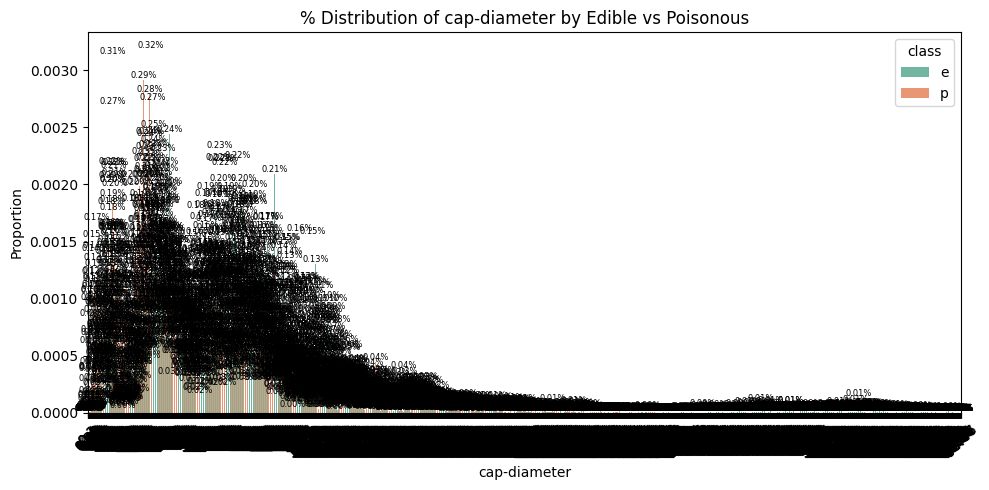

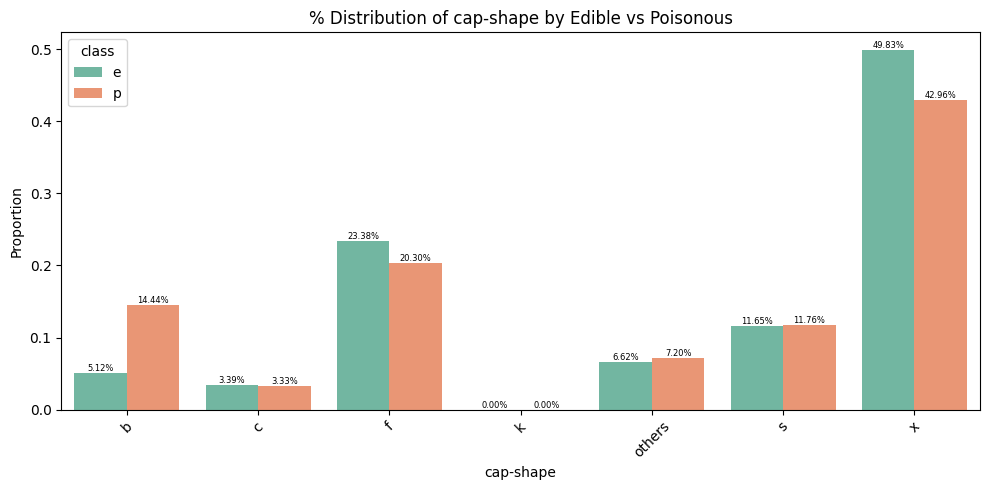

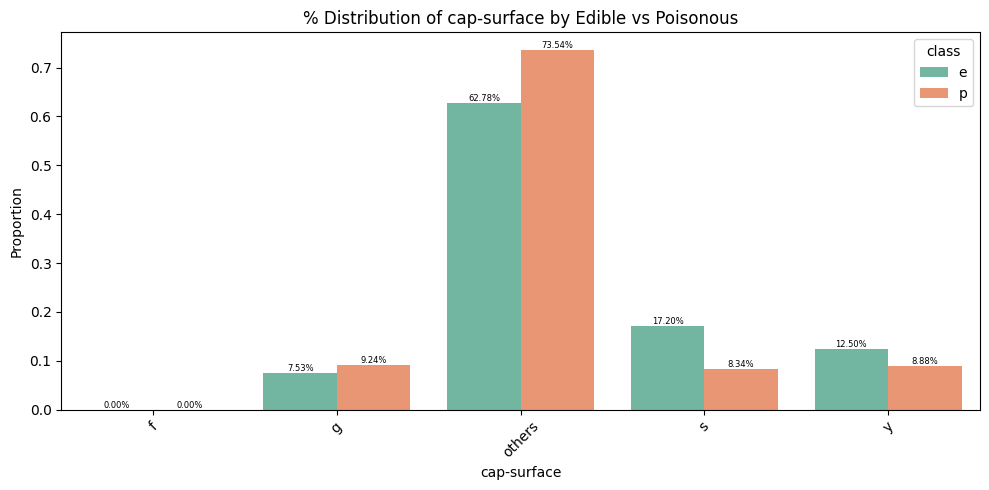

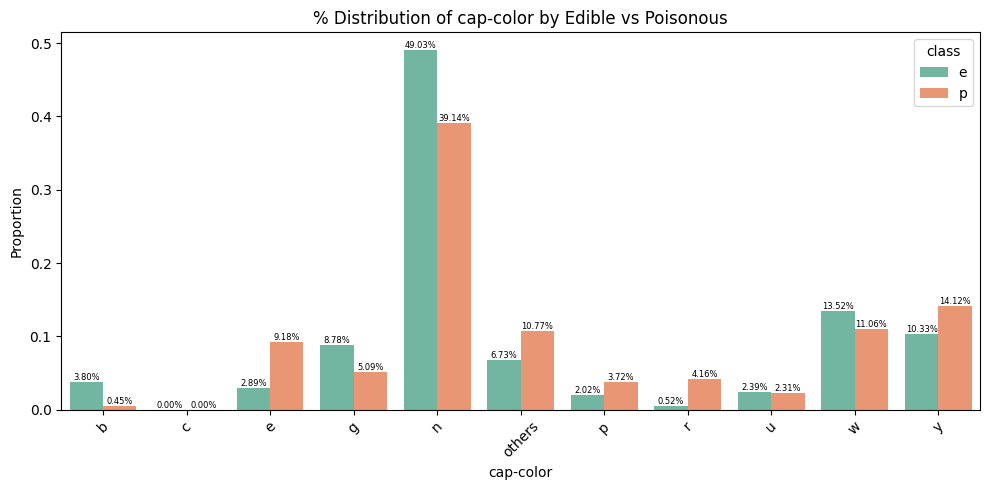

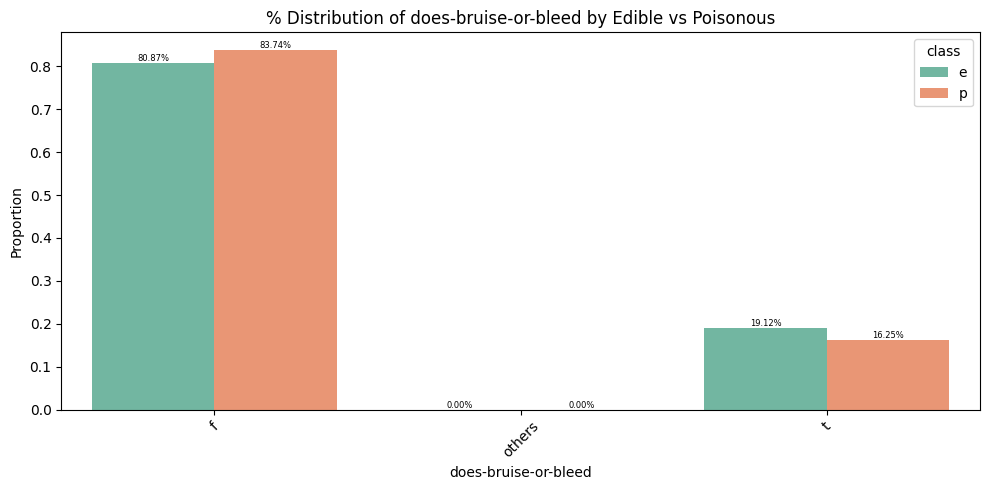

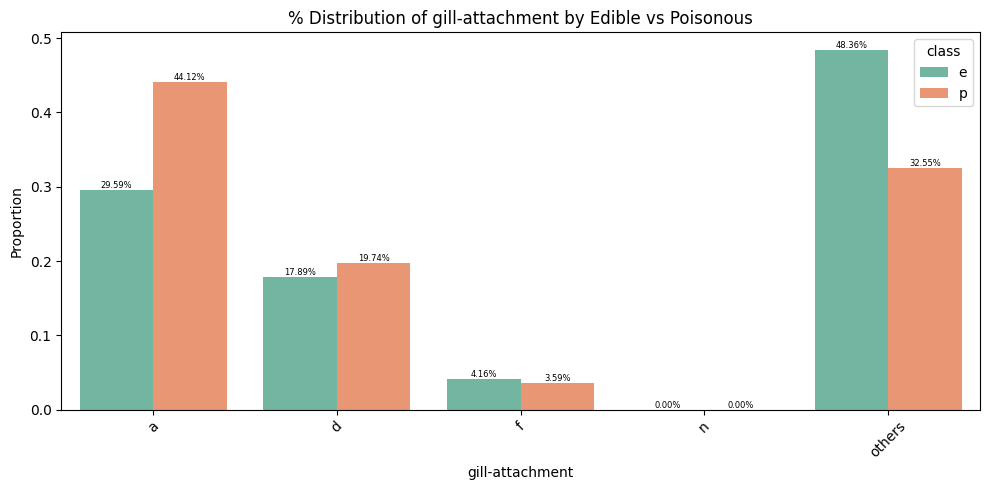

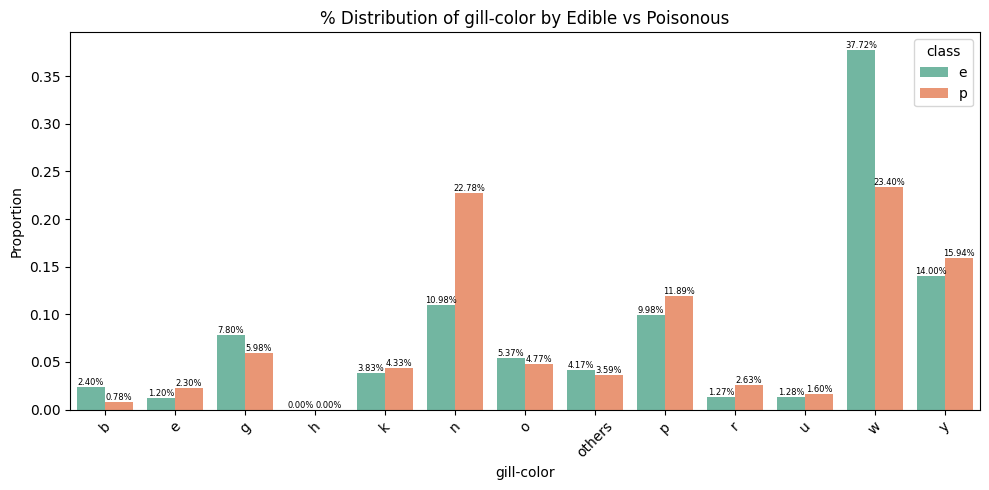

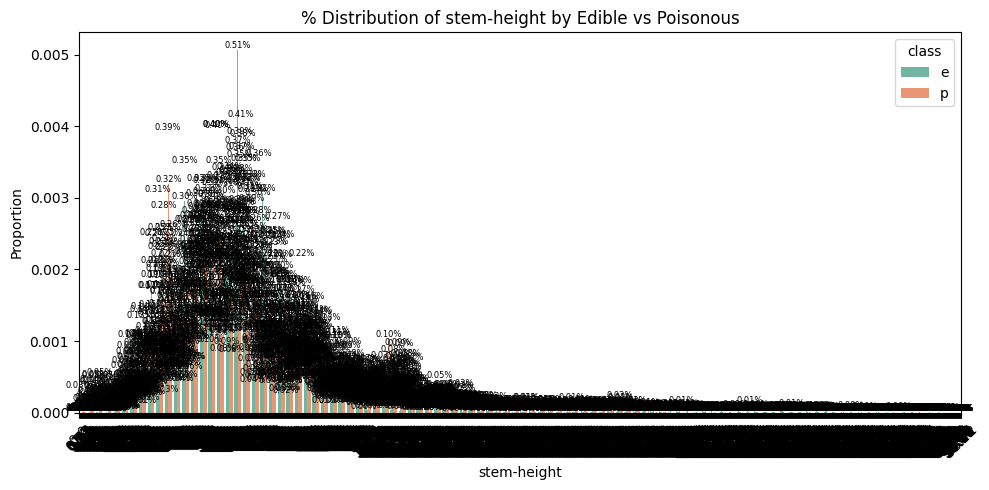

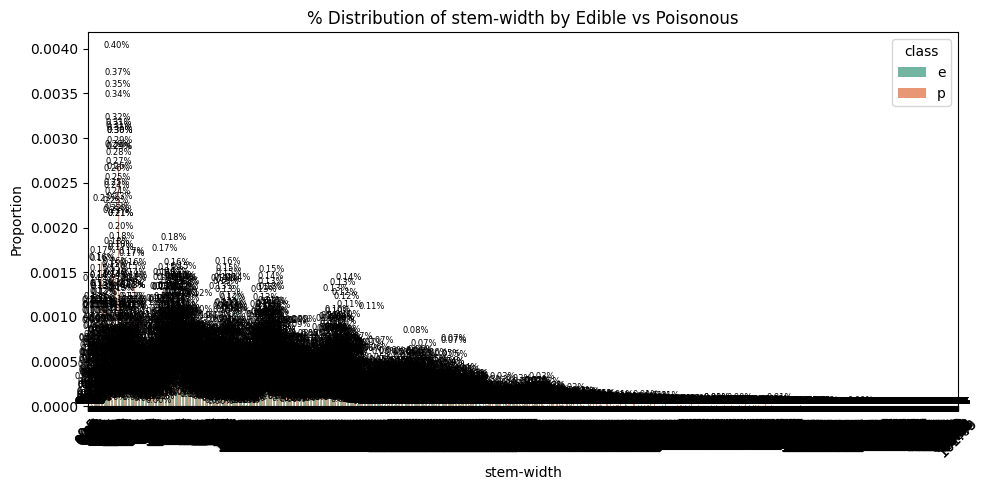

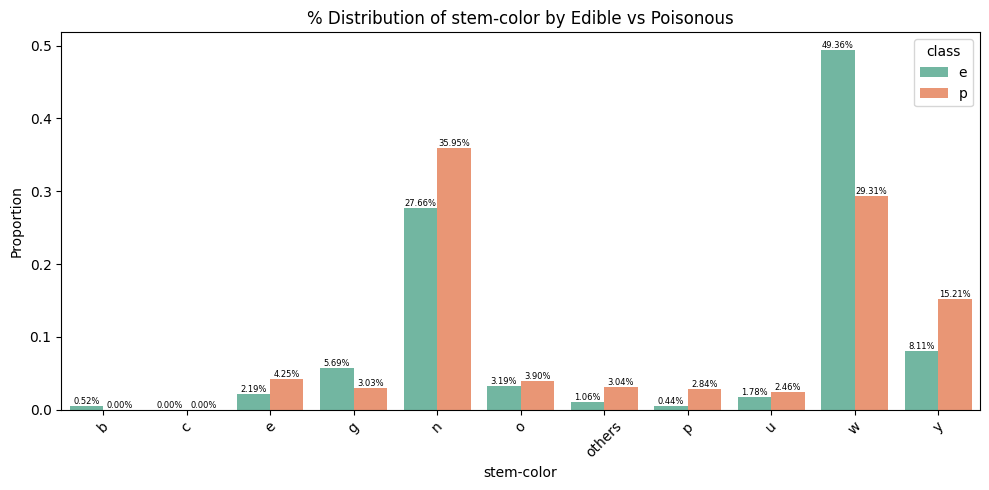

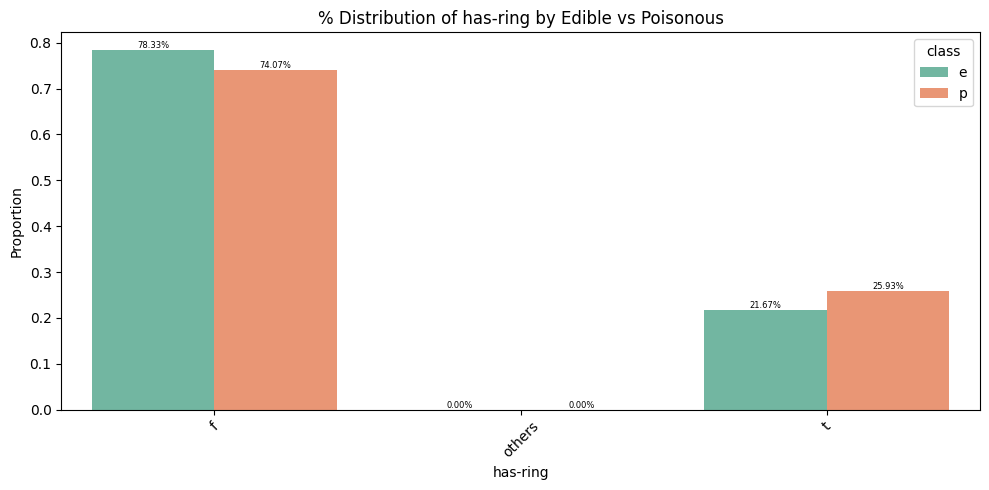

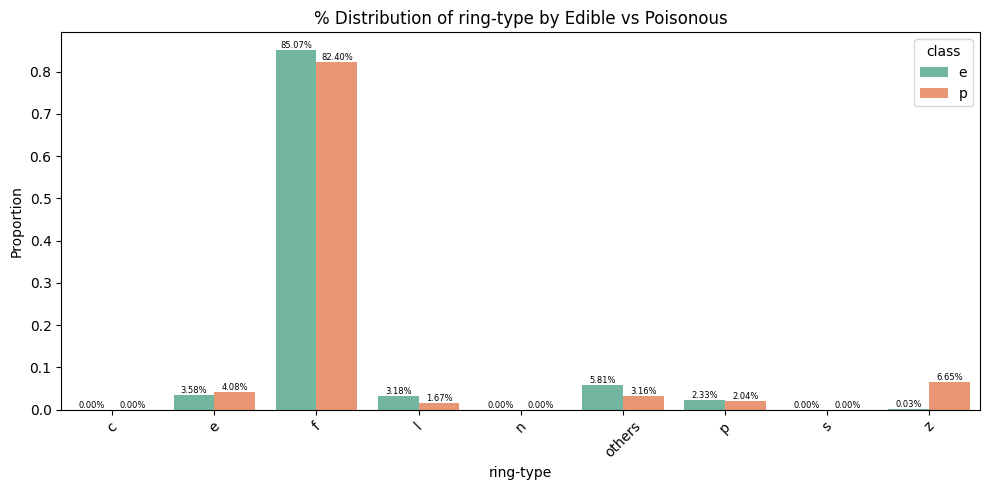

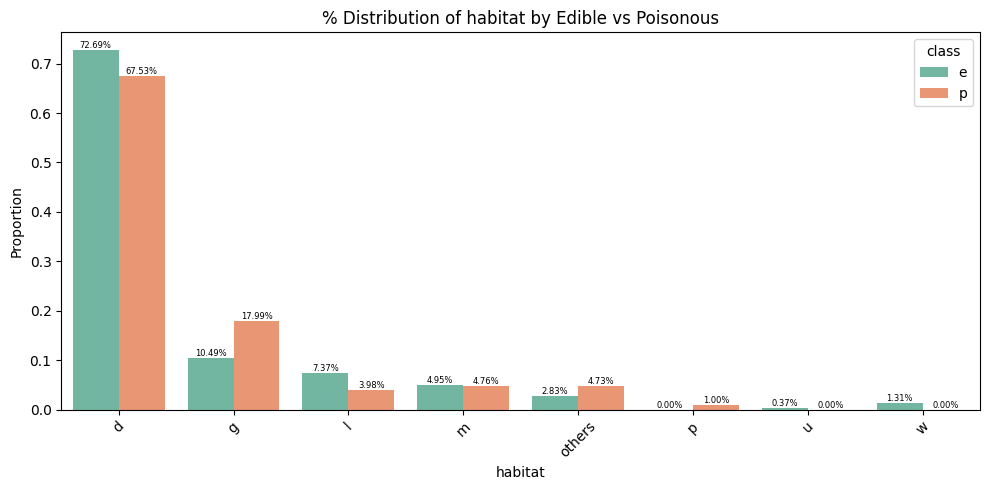

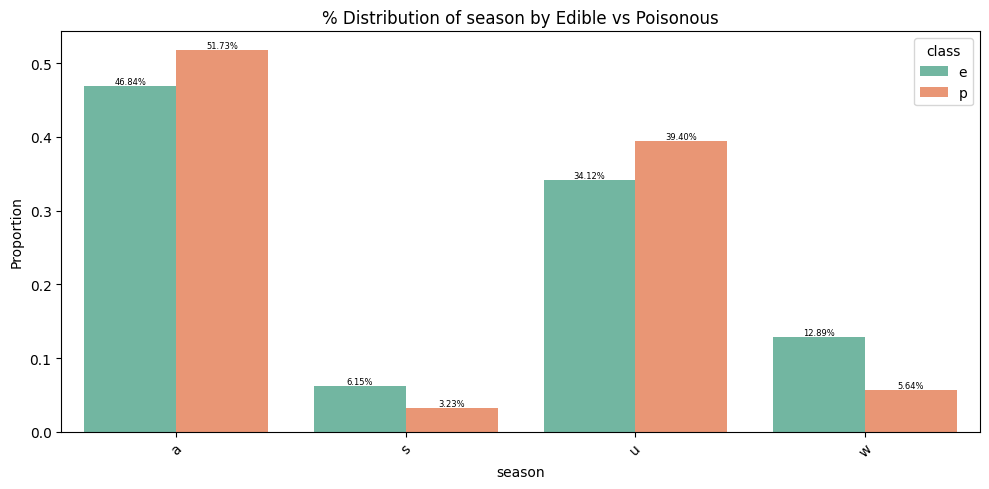

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate proportions and plot each categorical feature
for column in train_data_cleaned.columns[2:]:  # Adjust index if needed
    # Calculate the proportion of each category within each 'class'
    proportion_data = train_data_cleaned.groupby([column, 'class']).size().reset_index(name='count')
    
    # Get the total counts for each class to normalize by total class size
    total_class_counts = train_data_cleaned['class'].value_counts()
    
    # Calculate proportions based on class totals
    proportion_data['proportion'] = proportion_data.apply(
        lambda row: row['count'] / total_class_counts[row['class']],
        axis=1
    )
    
    # Plot the proportions
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=proportion_data, x=column, y='proportion', hue='class', palette='Set2')
    
    # Add labels to the bars, but only for non-zero proportions
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only label if height is greater than 0
            ax.annotate(f'{height:.2%}',  # Format as a percentage
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom',
                        fontsize=6)
    
    # Set title and labels
    plt.title(f'% Distribution of {column} by Edible vs Poisonous')
    plt.xlabel(column)
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


C:\Users\MSI-Z490\AppData\Local\Temp\ipykernel_20920\2080684446.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_data_cleaned, x='class', y=column, palette='Set2', ax=axes[i])
C:\Users\MSI-Z490\AppData\Local\Temp\ipykernel_20920\2080684446.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_data_cleaned, x='class', y=column, palette='Set2', ax=axes[i])
C:\Users\MSI-Z490\AppData\Local\Temp\ipykernel_20920\2080684446.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_data_cleaned, x='class', y=column, pa

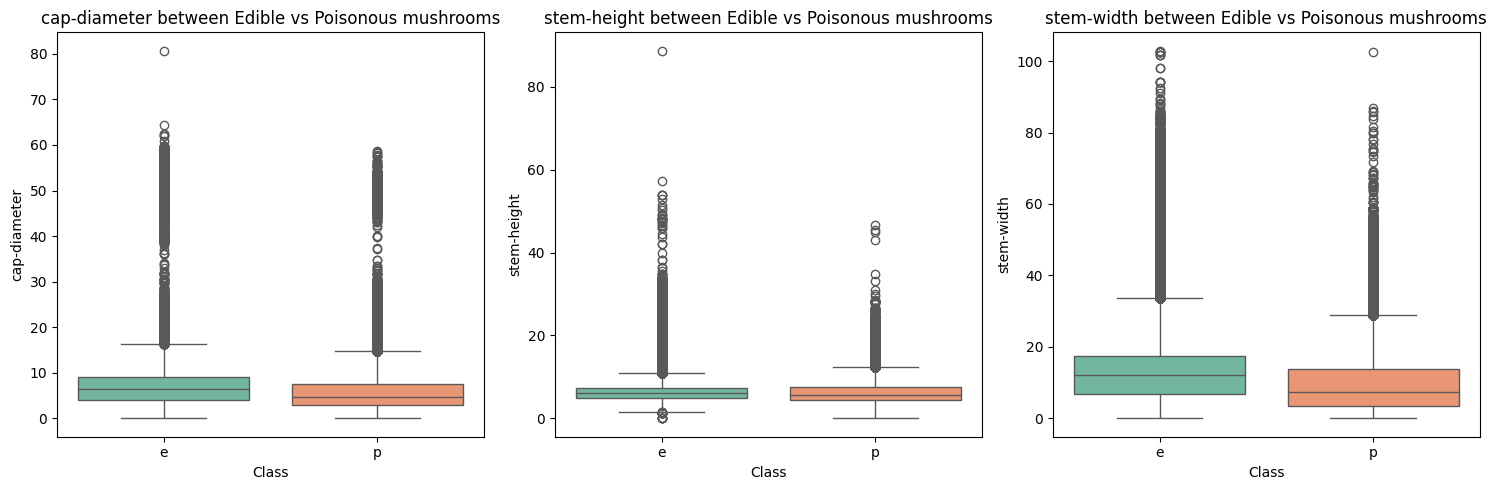

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Identify numerical columns in the dataset, excluding 'id'
numerical_columns = [col for col in train_data_cleaned.select_dtypes(include='number').columns if col != 'id']

# Set the number of columns for side-by-side plotting
num_plots = len(numerical_columns)
cols = 3  # Number of plots per row
rows = (num_plots // cols) + (num_plots % cols > 0)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axes = axes.flatten()

# Loop through each numerical column and create a boxplot
for i, column in enumerate(numerical_columns):
    sns.boxplot(data=train_data_cleaned, x='class', y=column, palette='Set2', ax=axes[i])
    axes[i].set_title(f'{column} between Edible vs Poisonous mushrooms')
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel(column)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


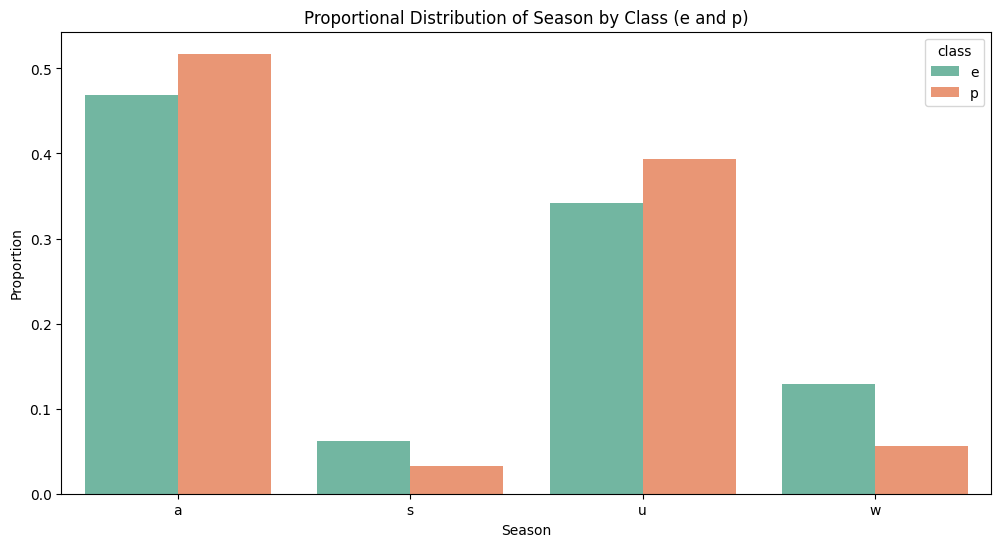

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the count for each 'season' and 'class' combination
proportion_data = train_data_cleaned.groupby(['season', 'class']).size().reset_index(name='count')

# Calculate the total count for each 'class'
total_class_counts = train_data_cleaned['class'].value_counts()

# Add a column for the proportion based on the total count of each class
proportion_data['proportion'] = proportion_data.apply(
    lambda row: row['count'] / total_class_counts[row['class']],
    axis=1
)

# Plot the proportions
plt.figure(figsize=(12, 6))
sns.barplot(data=proportion_data, x='season', y='proportion', hue='class', palette='Set2')

# Add labels and title
plt.title('Proportional Distribution of Season by Class (e and p)')
plt.xlabel('Season')
plt.ylabel('Proportion')

# Show the plot
plt.show()


C:\Users\MSI-Z490\AppData\Local\Temp\ipykernel_20920\2474892317.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data= train_data_cleaned, x='class', y='cap-diameter', palette='Set2')


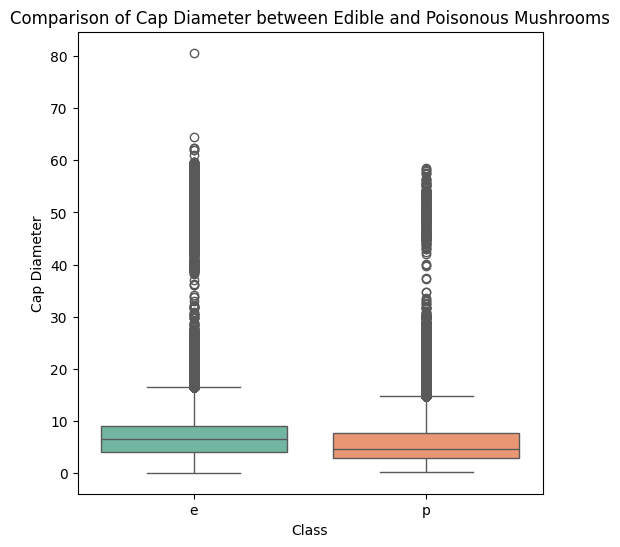

In [21]:
# Assuming train_data is already defined as your DataFrame
# Create the boxplot
plt.figure(figsize=(6, 6))
sns.boxplot(data= train_data_cleaned, x='class', y='cap-diameter', palette='Set2')

# Add labels and title
plt.title('Comparison of Cap Diameter between Edible and Poisonous Mushrooms')
plt.xlabel('Class')
plt.ylabel('Cap Diameter')

# Show the plot
plt.show()


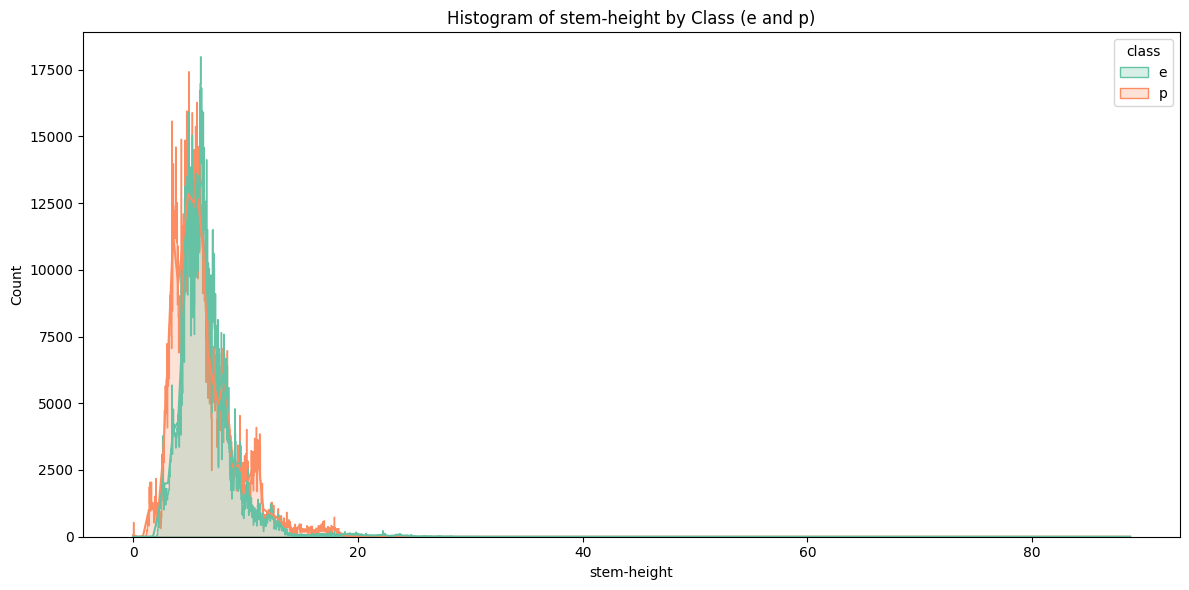

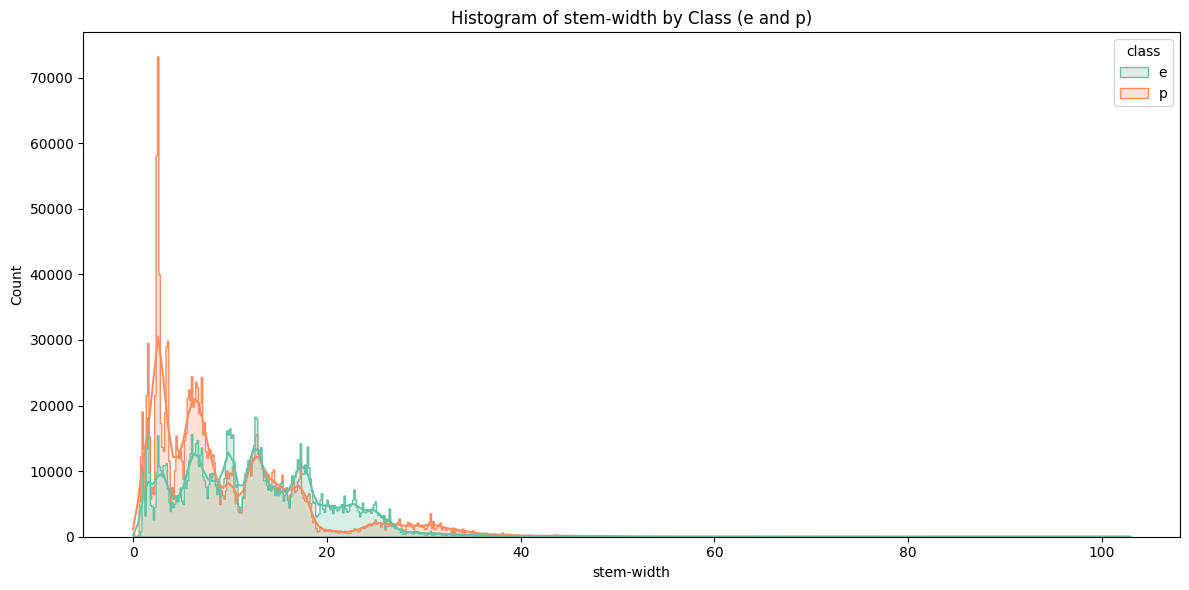

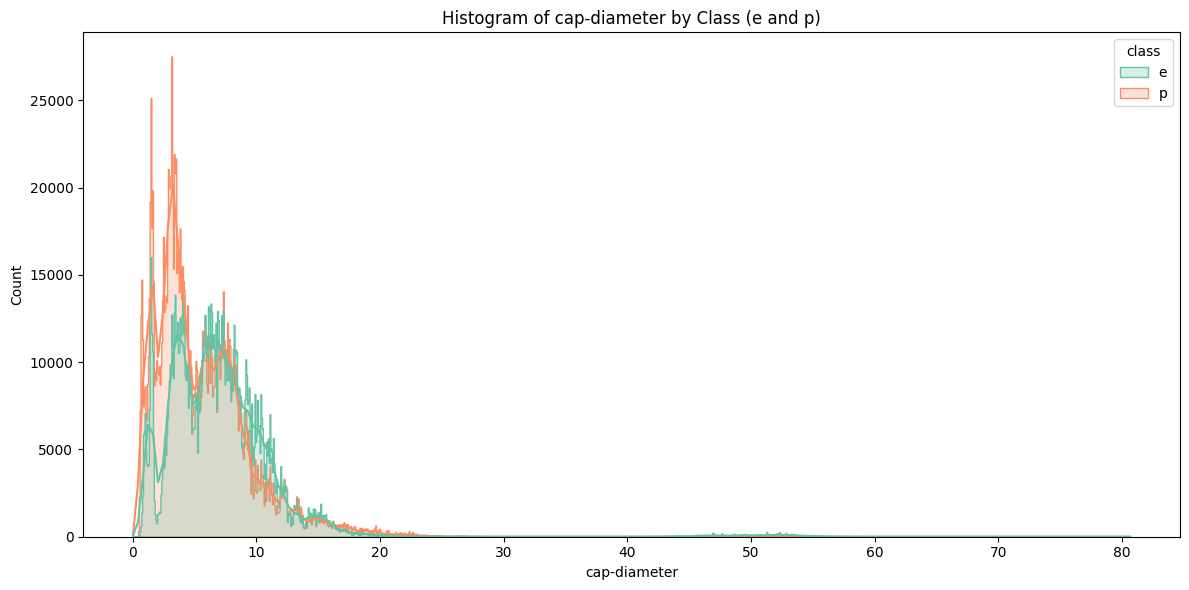

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of columns to plot
columns = ['stem-height', 'stem-width', 'cap-diameter']

# Loop through each column and plot histograms
for column in columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=train_data_cleaned, x=column, hue='class', kde=True, palette='Set2', element='step')
    
    # Set title and labels
    plt.title(f'Histogram of {column} by Class (e and p)')
    plt.xlabel(column)
    plt.ylabel('Count')
    
    # Show the plot
    plt.tight_layout()
    plt.show()


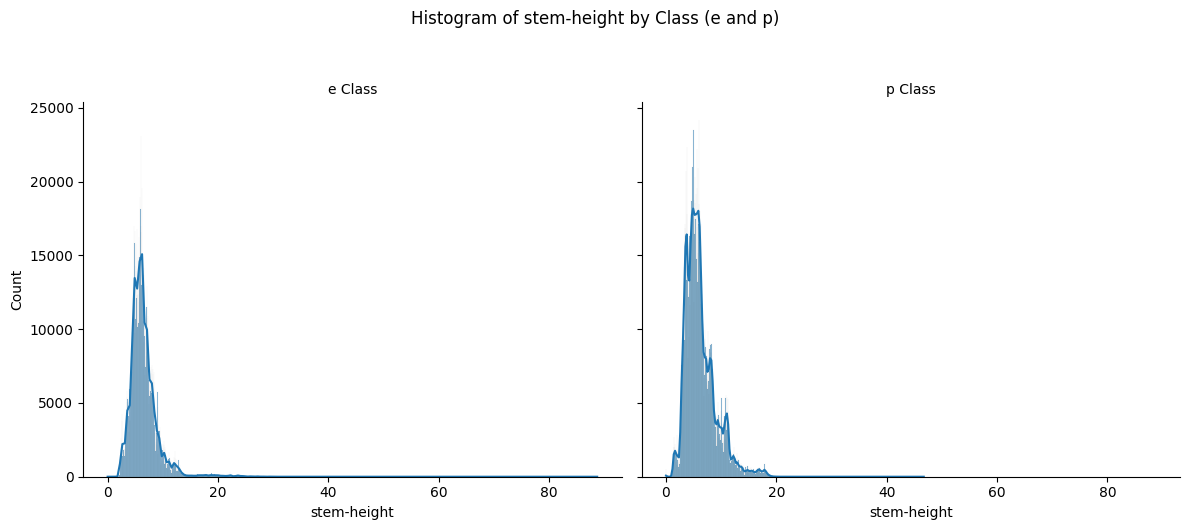

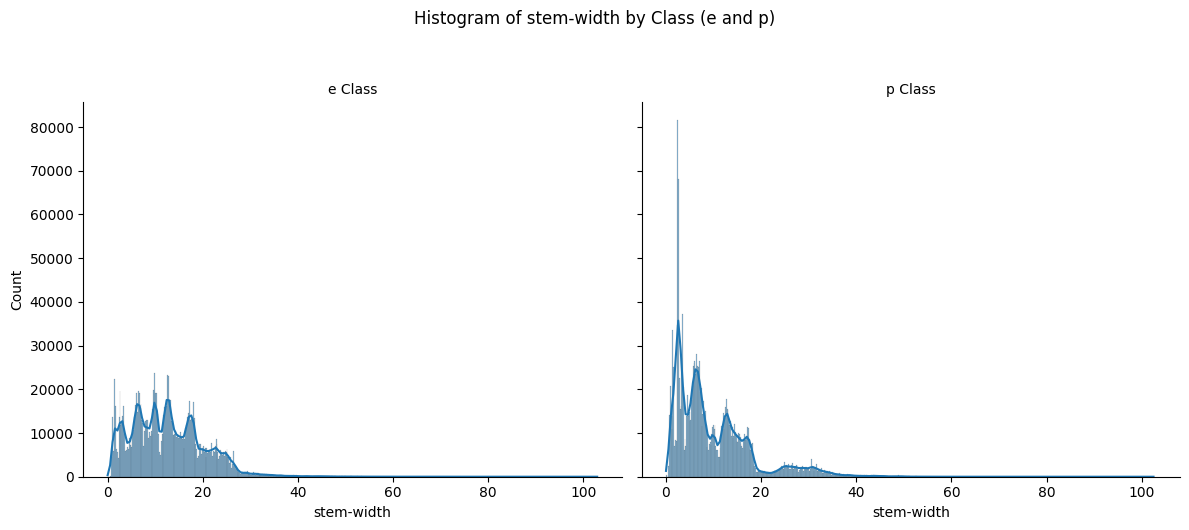

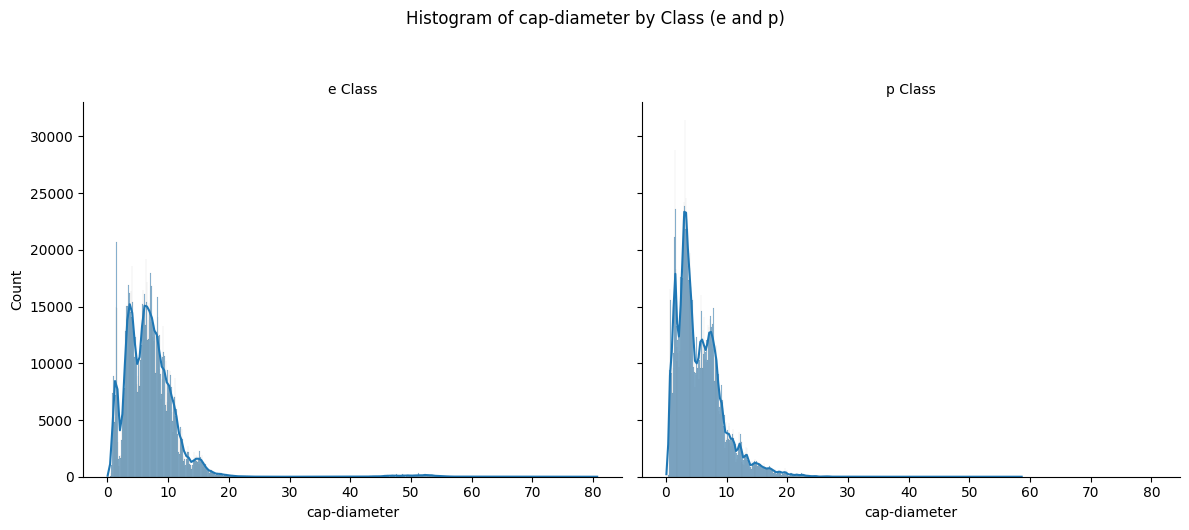

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of columns to plot
columns = ['stem-height', 'stem-width', 'cap-diameter']

# Loop through each column and create side-by-side plots for classes 'e' and 'p'
for column in columns:
    # Create a FacetGrid for side-by-side plots
    g = sns.FacetGrid(train_data_cleaned, col="class", palette='Set2', height=5, aspect=1.2)
    g.map(sns.histplot, column, kde=True)
    
    # Set titles and labels for each facet
    g.set_axis_labels(column, 'Count')
    g.set_titles(col_template="{col_name} Class")
    g.fig.suptitle(f'Histogram of {column} by Class (e and p)', y=1.05)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


Accuracy Score: 0.9870492918283277

Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.99      0.99    423456
        True       0.99      0.99      0.99    511628

    accuracy                           0.99    935084
   macro avg       0.99      0.99      0.99    935084
weighted avg       0.99      0.99      0.99    935084



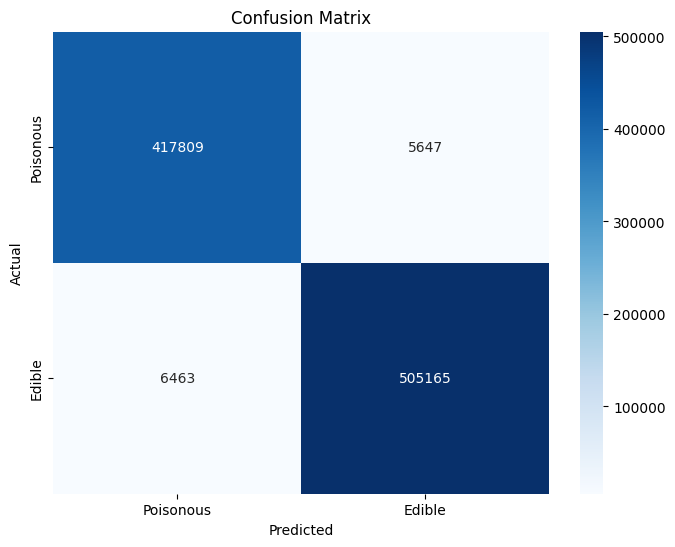

In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_data_cleaned' is your dataset
# Encode categorical variables using pd.get_dummies()
train_data_encoded = pd.get_dummies(train_data_cleaned, drop_first=True)

# Split data into features and target variable
X = train_data_encoded.drop('class_p', axis=1)  # 'class_e' or 'class_p' as the encoded target column
y = train_data_encoded['class_p']  # Binary target variable: edible (1) or poisonous (0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Print evaluation metrics
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Poisonous', 'Edible'], yticklabels=['Poisonous', 'Edible'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Cross-validation scores: [0.98692174 0.98716691 0.98723337 0.98711879 0.98672234]
Mean cross-validation score: 0.9870326295354701
Standard deviation of cross-validation scores: 0.0001867241834779123

Accuracy Score: 0.9870492918283277

Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.99      0.99    423456
        True       0.99      0.99      0.99    511628

    accuracy                           0.99    935084
   macro avg       0.99      0.99      0.99    935084
weighted avg       0.99      0.99      0.99    935084



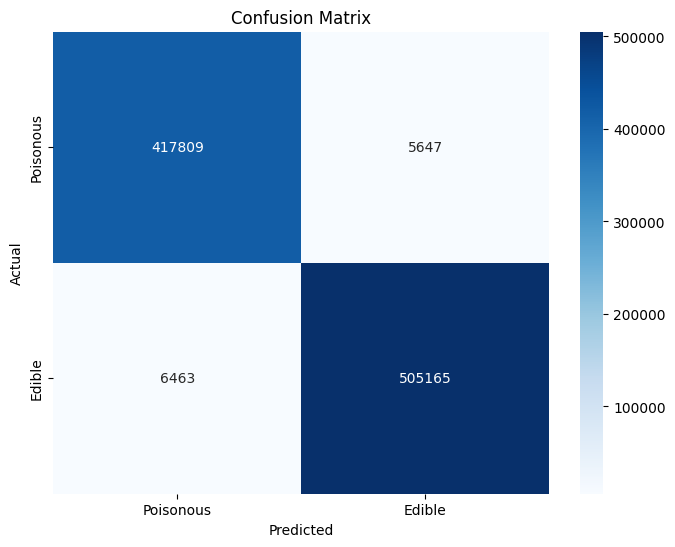

In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_data_cleaned' is your dataset
# Encode categorical variables using pd.get_dummies()
train_data_encoded = pd.get_dummies(train_data_cleaned, drop_first=True)

# Split data into features and target variable
X = train_data_encoded.drop('class_p', axis=1)  # 'class_e' or 'class_p' as the encoded target column
y = train_data_encoded['class_p']  # Binary target variable: edible (1) or poisonous (0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)  # Using 5-fold cross-validation

# Print cross-validation results
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))
print("Standard deviation of cross-validation scores:", np.std(cv_scores))

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Print evaluation metrics
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Poisonous', 'Edible'], yticklabels=['Poisonous', 'Edible'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
70 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
53 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\sk

Best Hyperparameters: {'bootstrap': False, 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 189}

Accuracy Score: 0.9837148320364801

Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.98      0.98    423456
        True       0.99      0.98      0.99    511628

    accuracy                           0.98    935084
   macro avg       0.98      0.98      0.98    935084
weighted avg       0.98      0.98      0.98    935084



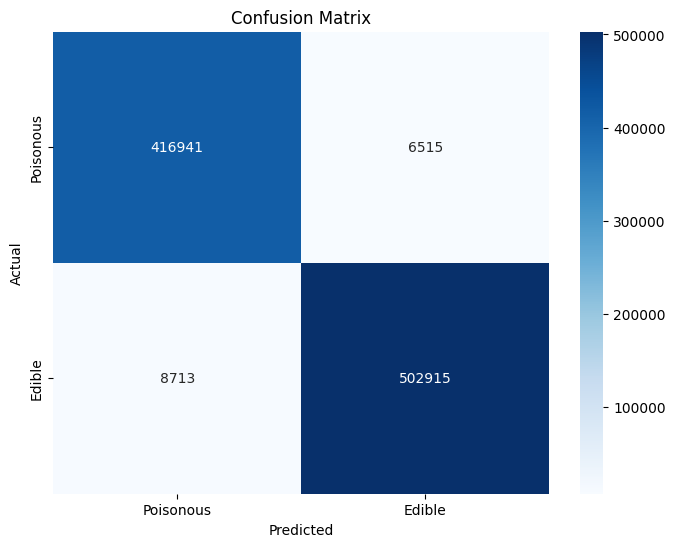

In [26]:
train_data_encoded = pd.get_dummies(train_data_cleaned, drop_first=True)
X = train_data_encoded.drop('class_p', axis=1)  # 'class_e' or 'class_p' as the encoded target column
y = train_data_encoded['class_p']  # Binary target variable: edible (1) or poisonous (0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Define hyperparameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 300),          # Number of trees
    'max_depth': randint(3, 20),               # Maximum depth of trees
    'min_samples_split': randint(2, 20),       # Minimum samples required to split a node
    'min_samples_leaf': randint(1, 20),        # Minimum samples required at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'bootstrap': [True, False]                 # Whether bootstrap samples are used
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model, 
    param_distributions=param_dist,
    n_iter=50,            # Number of parameter settings to sample
    scoring='accuracy',   # Use accuracy as the evaluation metric
    n_jobs=-1,            # Use all available cores
    cv=5,                 # 5-fold cross-validation
    verbose=2, 
    random_state=42
)

# Fit RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", random_search.best_params_)

# Train the best model
best_rf_model = random_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Make predictions using the tuned model
y_pred = best_rf_model.predict(X_test)

# Print evaluation metrics
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Poisonous', 'Edible'], yticklabels=['Poisonous', 'Edible'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Accuracy Score: 0.5471465665116717

Classification Report:


C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

       False       0.00      0.00      0.00    423456
        True       0.55      1.00      0.71    511628

    accuracy                           0.55    935084
   macro avg       0.27      0.50      0.35    935084
weighted avg       0.30      0.55      0.39    935084



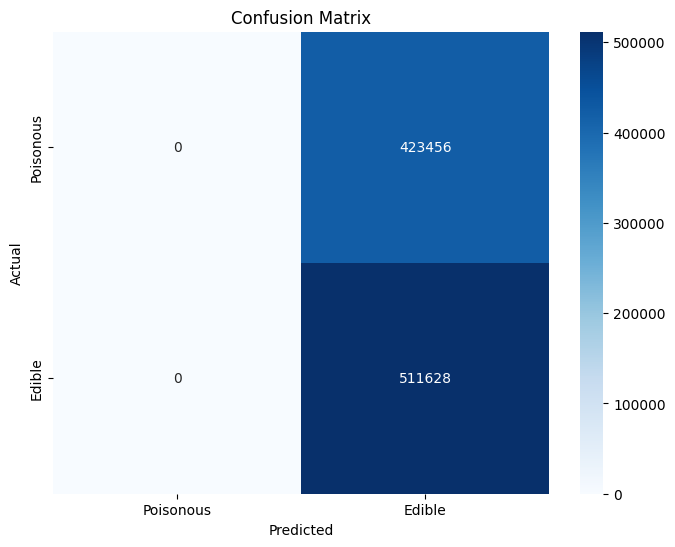

In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_data_cleaned' is your dataset
# Encode categorical variables using pd.get_dummies()
train_data_encoded = pd.get_dummies(train_data_cleaned, drop_first=True)

# Split data into features and target variable
X = train_data_encoded.drop('class_p', axis=1)  # 'class_e' or 'class_p' as the encoded target column
y = train_data_encoded['class_p']  # Binary target variable: edible (1) or poisonous (0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Logistic Regression model
log_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_model.fit(X_train, y_train)

# Make predictions
y_pred = log_model.predict(X_test)

# Print evaluation metrics
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Poisonous', 'Edible'], yticklabels=['Poisonous', 'Edible'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Accuracy Score: 0.5471465665116717

Classification Report:


C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

       False       0.00      0.00      0.00    423456
        True       0.55      1.00      0.71    511628

    accuracy                           0.55    935084
   macro avg       0.27      0.50      0.35    935084
weighted avg       0.30      0.55      0.39    935084



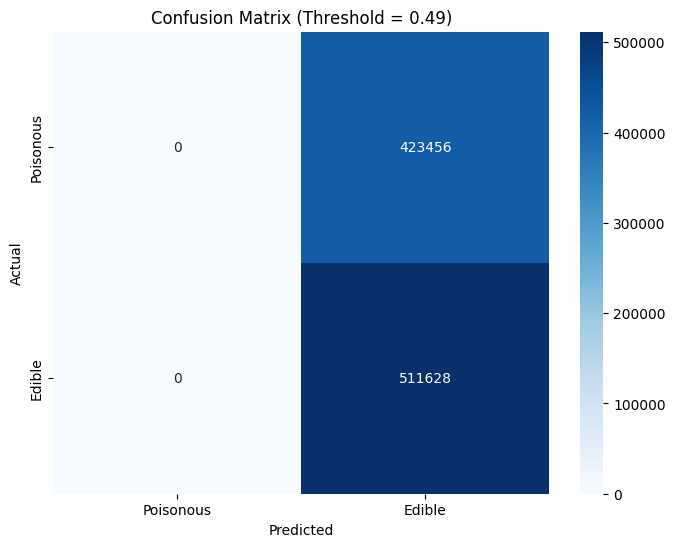

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_data_cleaned' is your dataset
# Encode categorical variables using pd.get_dummies()
train_data_encoded = pd.get_dummies(train_data_cleaned, drop_first=True)

# Split data into features and target variable
X = train_data_encoded.drop('class_p', axis=1)
y = train_data_encoded['class_p']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Logistic Regression model
log_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = log_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Apply custom threshold of 0.3
threshold = 0.49
y_pred = (y_pred_proba >= threshold).astype(int)

# Print evaluation metrics
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Poisonous', 'Edible'], yticklabels=['Poisonous', 'Edible'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()


Cross-Validation Scores: [0.54713513 0.5471341  0.5471341  0.5471318  0.5471318 ]
Mean Cross-Validation Score: 0.5471333875064696

Accuracy Score: 0.5471465665116717

Classification Report:


C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

       False       0.00      0.00      0.00    423456
        True       0.55      1.00      0.71    511628

    accuracy                           0.55    935084
   macro avg       0.27      0.50      0.35    935084
weighted avg       0.30      0.55      0.39    935084



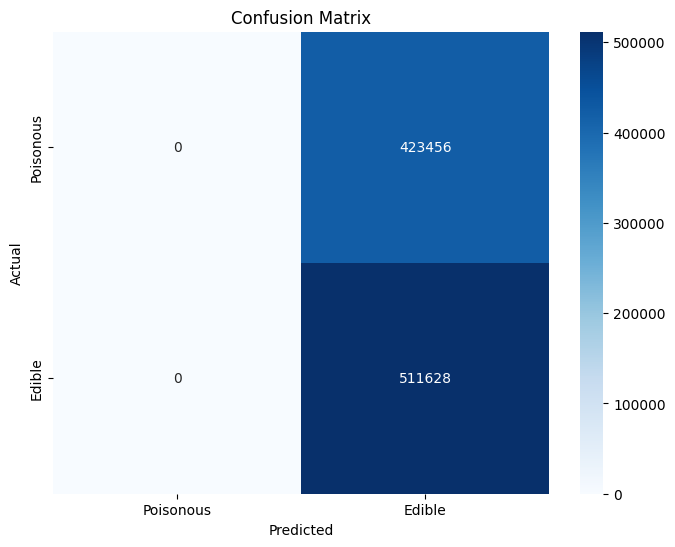

In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_data_cleaned' is your dataset
# Encode categorical variables using pd.get_dummies()
train_data_encoded = pd.get_dummies(train_data_cleaned, drop_first=True)

# Split data into features and target variable
X = train_data_encoded.drop('class_p', axis=1)  # 'class_e' or 'class_p' as the encoded target column
y = train_data_encoded['class_p']  # Binary target variable: edible (1) or poisonous (0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Logistic Regression model
log_model = LogisticRegression(max_iter=1000, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(log_model, X_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

# Train the model on the entire training set
log_model.fit(X_train, y_train)

# Make predictions
y_pred = log_model.predict(X_test)

# Print evaluation metrics
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Poisonous', 'Edible'], yticklabels=['Poisonous', 'Edible'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\xgboost\core.py:158: UserWarning: [08:23:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy Score: 0.983977910005946

Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.98      0.98    423456
        True       0.99      0.98      0.99    511628

    accuracy                           0.98    935084
   macro avg       0.98      0.98      0.98    935084
weighted avg       0.98      0.98      0.98    935084



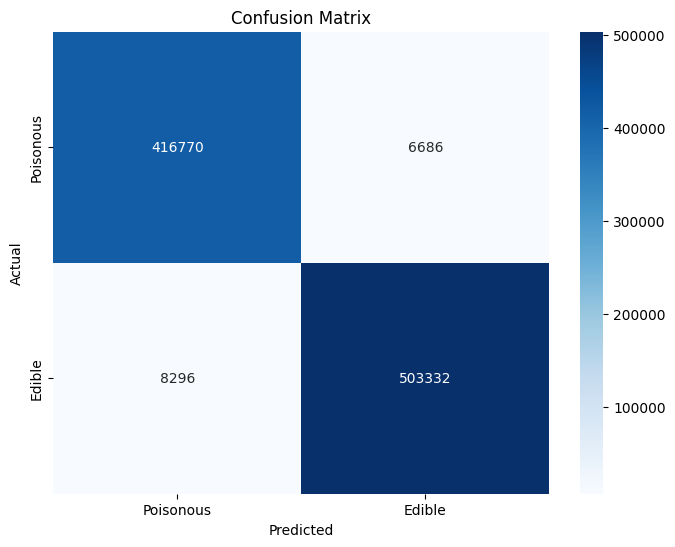

In [30]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_data_cleaned' is your dataset
# Encode categorical variables using pd.get_dummies()
train_data_encoded = pd.get_dummies(train_data_cleaned, drop_first=True)

# Split data into features and target variable
X = train_data_encoded.drop('class_p', axis=1)  # 'class_e' or 'class_p' as the encoded target column
y = train_data_encoded['class_p']  # Binary target variable: edible (1) or poisonous (0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create an XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Print evaluation metrics
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Poisonous', 'Edible'], yticklabels=['Poisonous', 'Edible'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\xgboost\core.py:158: UserWarning: [09:47:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\xgboost\core.py:158: UserWarning: [09:48:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\xgboost\core.py:158: UserWarning: [09:48:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encod

Cross-Validation Accuracy Scores: [0.98413992 0.98418163 0.98428429 0.98419606 0.98460351]
Mean Accuracy: 0.9842810829193329
Standard Deviation: 0.00016793996847998163


C:\Users\MSI-Z490\Documents\Anaconda\envs\Python 05212024\lib\site-packages\xgboost\core.py:158: UserWarning: [09:49:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Accuracy Score on Test Set: 0.983977910005946

Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.98      0.98      0.98    423456
        True       0.99      0.98      0.99    511628

    accuracy                           0.98    935084
   macro avg       0.98      0.98      0.98    935084
weighted avg       0.98      0.98      0.98    935084



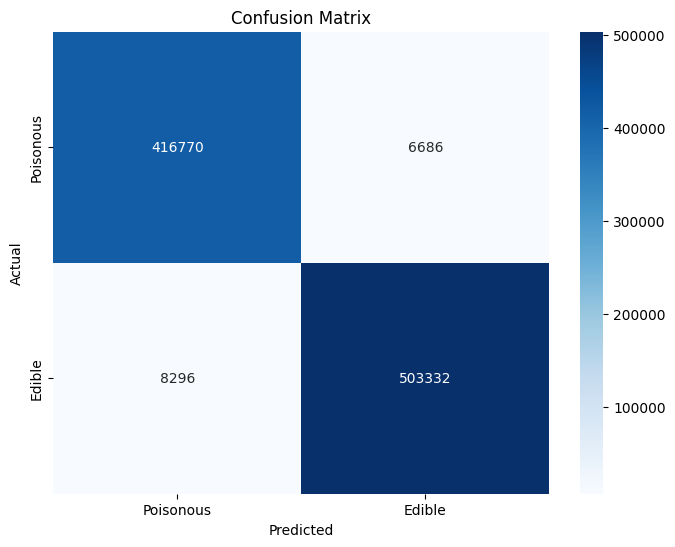

In [46]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_data_cleaned' is your dataset
# Encode categorical variables using pd.get_dummies()
train_data_encoded = pd.get_dummies(train_data_cleaned, drop_first=True)

# Split data into features and target variable
X = train_data_encoded.drop('class_p', axis=1)
y = train_data_encoded['class_p']

# Perform cross-validation
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Use cross-validation with 5 folds
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')

# Print cross-validation results
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))

# Train-test split for further evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model on the training set
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Print evaluation metrics on the test set
print("\nAccuracy Score on Test Set:", accuracy_score(y_test, y_pred))
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Poisonous', 'Edible'], yticklabels=['Poisonous', 'Edible'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Accuracy Score: 0.9750471615384286

Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.97      0.97    423456
        True       0.98      0.98      0.98    511628

    accuracy                           0.98    935084
   macro avg       0.97      0.97      0.97    935084
weighted avg       0.98      0.98      0.98    935084



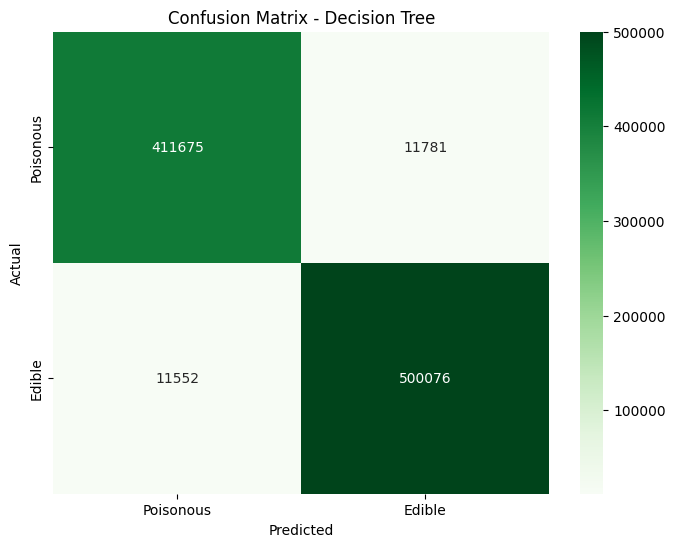

In [34]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_data_cleaned' is your dataset
# Encode categorical variables using pd.get_dummies()
train_data_encoded = pd.get_dummies(train_data_cleaned, drop_first=True)

# Split data into features and target variable
X = train_data_encoded.drop('class_p', axis=1)  # 'class_e' or 'class_p' as the encoded target column
y = train_data_encoded['class_p']  # Binary target variable: edible (1) or poisonous (0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)

# Print evaluation metrics
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Poisonous', 'Edible'], yticklabels=['Poisonous', 'Edible'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()


Accuracy Score: 0.8753235003486318

Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.92      0.87    423456
        True       0.93      0.84      0.88    511628

    accuracy                           0.88    935084
   macro avg       0.88      0.88      0.88    935084
weighted avg       0.88      0.88      0.88    935084



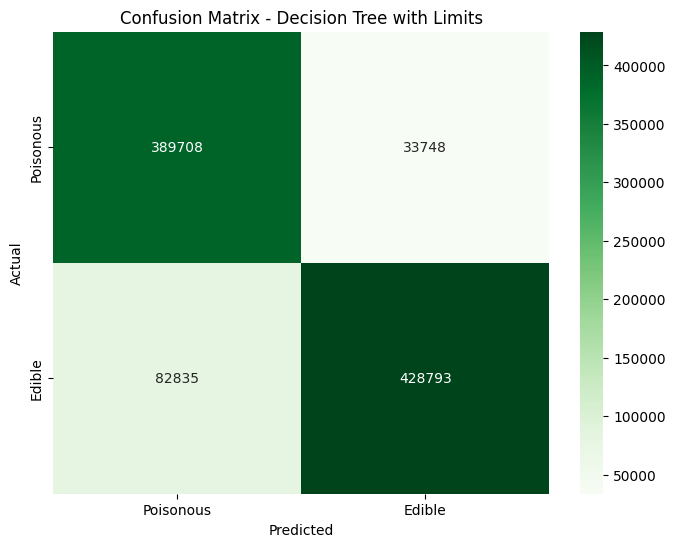

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_data_cleaned' is your dataset
# Encode categorical variables using pd.get_dummies()
train_data_encoded = pd.get_dummies(train_data_cleaned, drop_first=True)

# Split data into features and target variable
X = train_data_encoded.drop('class_p', axis=1)
y = train_data_encoded['class_p']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Decision Tree Classifier with limits to avoid overfitting
dt_model = DecisionTreeClassifier(
    max_depth=10,            # Limit the depth of the tree
    min_samples_split=20,    # Minimum samples required to split a node
    min_samples_leaf=10,     # Minimum samples required at a leaf node
    random_state=42
)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)

# Print evaluation metrics
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Poisonous', 'Edible'], yticklabels=['Poisonous', 'Edible'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree with Limits')
plt.show()


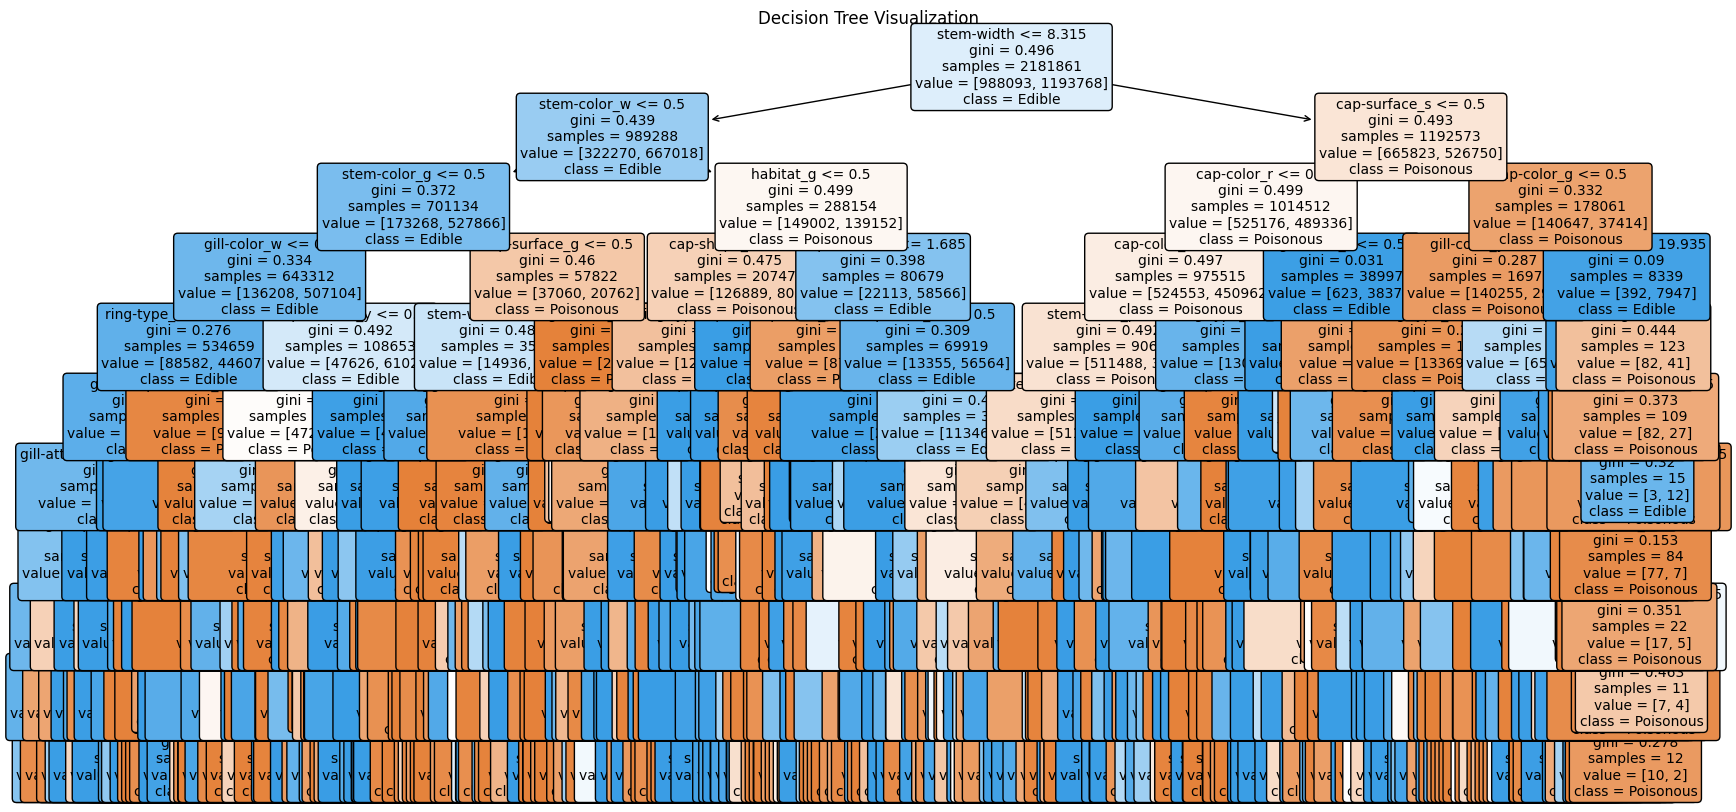

In [37]:
from sklearn.tree import plot_tree

# Set figure size for better readability
plt.figure(figsize=(20, 10))
plot_tree(dt_model, 
          feature_names=X.columns, 
          class_names=['Poisonous', 'Edible'], 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()


Cross-Validation Accuracy Scores: [0.90339579 0.9765283  0.97619785 0.97620908 0.90860763]
Mean Accuracy: 0.9481877286894699
Standard Deviation: 0.03448435178520005

Accuracy Score on Test Set: 0.9750471615384286

Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.97      0.97      0.97    423456
        True       0.98      0.98      0.98    511628

    accuracy                           0.98    935084
   macro avg       0.97      0.97      0.97    935084
weighted avg       0.98      0.98      0.98    935084



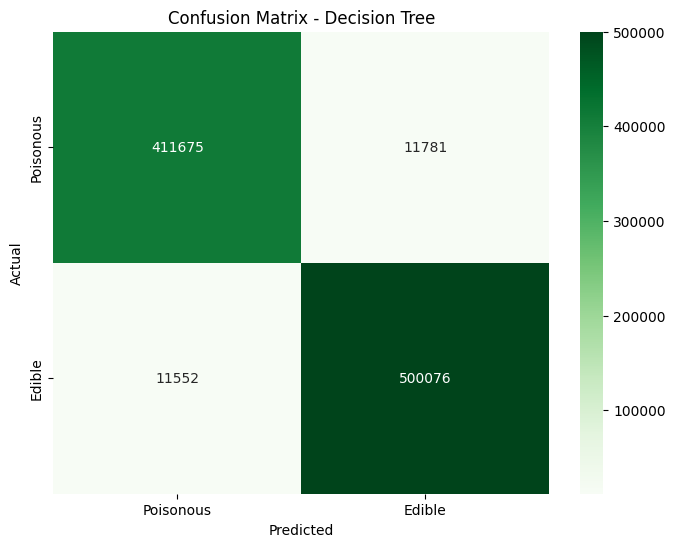

In [49]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_data_cleaned' is your dataset
# Encode categorical variables using pd.get_dummies()
train_data_encoded = pd.get_dummies(train_data_cleaned, drop_first=True)

# Split data into features and target variable
X = train_data_encoded.drop('class_p', axis=1)  # Features
y = train_data_encoded['class_p']  # Target variable

# Create a Decision Tree Classifier without specific limits
dt_model = DecisionTreeClassifier(random_state=42)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(dt_model, X, y, cv=5, scoring='accuracy')

# Print cross-validation results
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))

# Split the data into training and testing sets for further evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model on the training set
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_model.predict(X_test)

# Print evaluation metrics on the test set
print("\nAccuracy Score on Test Set:", accuracy_score(y_test, y_pred))
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Poisonous', 'Edible'], yticklabels=['Poisonous', 'Edible'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()
